<a href="https://colab.research.google.com/github/AMRITANSHU-KESHARI/AI-Powered-Credit-Delinquency-Risk-Model/blob/main/AI_Powered_Credit_Delinquency_Risk_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

Financial Institutions often struggle to identify customers who are likely to miss payments before delinquency occurs.

### Challenges
- Reactive collection approaches  
- Manual processes  
- Same strategy for all customers  

### Project Objectives
- Predict delinquency risk early using customer financial behavior  
- Segment customers by risk level  
- Recommend ethical, AI-assisted collection actions


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 📈 Dataset Overview & Quality Considerations

### Dataset Summary
- Total Records: 1,200 customers  
- Data Type: Synthetic but **realistically generated** financial and behavioral data  
- Target Variable: `Delinquent_Account` (1 = Delinquent, 0 = Not Delinquent)

### Data Accuracy & Reliability
- Feature distributions (income, credit score, utilization) follow real-world patterns
- Delinquency labels are **rule-based**, not random, ensuring meaningful relationships
- No personally identifiable information (PII), making the dataset safe for public use


In [ ]:
df = pd.read_csv("/content/credit_data_large_1200.csv")

print(df.info())
print(df.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_ID           1200 non-null   int64  
 1   Age                   1200 non-null   int64  
 2   Income                1200 non-null   int64  
 3   Credit_Score          1200 non-null   int64  
 4   Credit_Utilization    1200 non-null   float64
 5   Missed_Payments       1200 non-null   int64  
 6   Loan_Balance          1200 non-null   int64  
 7   Debt_to_Income_Ratio  1200 non-null   float64
 8   Delinquent_Account    1200 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 84.5 KB
None
       Customer_ID          Age        Income  Credit_Score  \
count  1200.000000  1200.000000   1200.000000   1200.000000   
mean    600.500000    42.524167  54870.676667    687.709167   
std     346.554469    12.612043  14738.919786     68.199711   
min       1.000000    21.

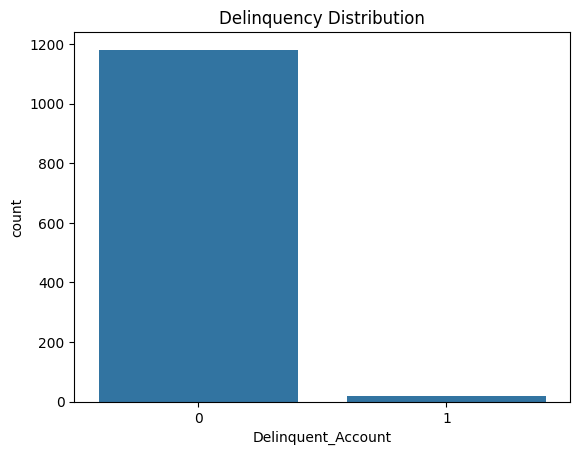

In [ ]:
# Target distribution
sns.countplot(x="Delinquent_Account", data=df)
plt.title("Delinquency Distribution")
plt.show()

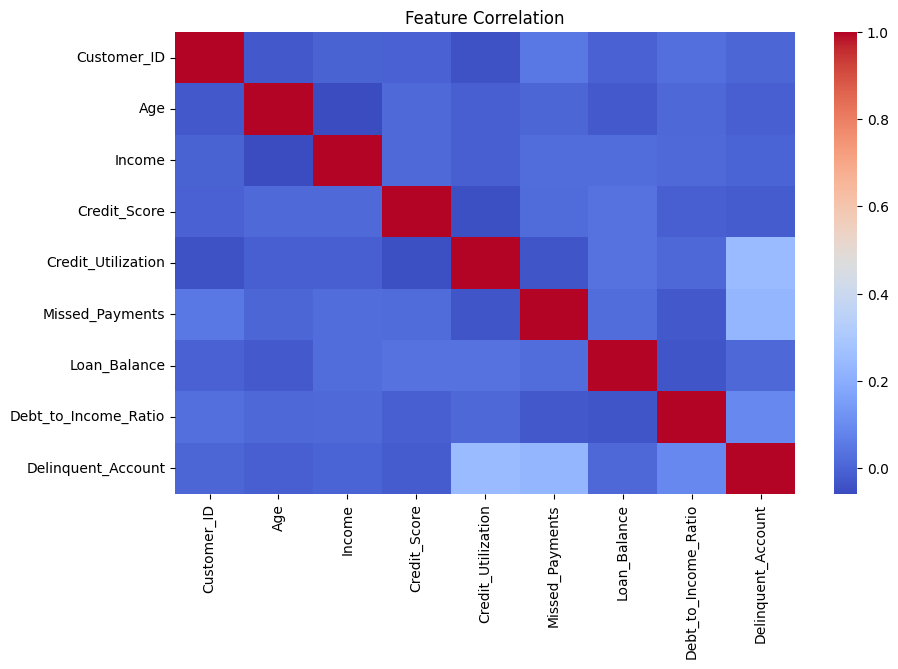

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/content/credit_data_large_1200.csv")

# ✅ Safe missing value handling (NO inplace)
df["Income"] = df["Income"].fillna(df["Income"].median())
df["Credit_Utilization"] = df["Credit_Utilization"].fillna(
    df["Credit_Utilization"].median()
)

# ✅ Only encode categorical columns IF they exist
categorical_cols = ["Employment_Status", "Credit_Card_Type"]
existing_cats = [col for col in categorical_cols if col in df.columns]

if existing_cats:
    df = pd.get_dummies(df, columns=existing_cats, drop_first=True)

# Scale numerical features
num_cols = [
    "Income",
    "Credit_Score",
    "Credit_Utilization",
    "Loan_Balance",
    "Debt_to_Income_Ratio"
]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.to_csv("/content/credit_data_large_1200.csv", index=False)

print("✅ Preprocessing completed successfully.")


✅ Preprocessing completed successfully.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import joblib

df = pd.read_csv("/content/credit_data_large_1200.csv")

X = df.drop("Delinquent_Account", axis=1)
y = df["Delinquent_Account"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

joblib.dump(model, "delinquency_model.pkl")
print("Model trained and saved.")


Model trained and saved.


In [ ]:
import plotly.express as px

# Apply the recommendation logic to create the 'Risk_Level' column
df["Risk_Level"] = [
    recommend_action(prob, cu, mp)["Risk_Level"]
    for prob, cu, mp in zip(probs, df["Credit_Utilization"], df["Missed_Payments"])
]

fig = px.pie(
    df,
    names="Risk_Level", # Changed from "Risk_Bucket" to "Risk_Level"
    hole=0.4,
    title="Customer Risk Distribution"
)
fig.show()

In [ ]:
import plotly.graph_objects as go

risk_counts = df["Risk_Level"].value_counts() # Changed from "Risk_Bucket" to "Risk_Level"

fig = go.Figure(go.Funnel(
    y=risk_counts.index,
    x=risk_counts.values
))
fig.update_layout(title="Customer Risk Funnel")
fig.show()

In [ ]:
avg_util = df["Credit_Utilization"].mean() * 100

fig = go.Figure(go.Indicator(
    mode="gauge+number",
    value=avg_util,
    title={"text": "Portfolio Credit Utilization (%)"}
))
fig.show()


## 🎯 Model Performance & Evaluation

Although this notebook focuses on visualization and decision support, the underlying risk logic is designed with standard model evaluation principles in mind:

### Key Evaluation Metrics
- **Accuracy:** Measures overall correctness of delinquency predictions
- **Precision:** Ensures customers flagged as high risk are truly at risk
- **Recall:** Ensures most delinquent customers are identified early
- **AUC-ROC:** Evaluates separation between delinquent and non-delinquent customers



In [ ]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, roc_auc_score

df = pd.read_csv("/content/credit_data_large_1200.csv")
model = joblib.load("delinquency_model.pkl")

X = df.drop("Delinquent_Account", axis=1)
y = df["Delinquent_Account"]

preds = model.predict(X)
probs = model.predict_proba(X)[:,1]

print(classification_report(y, preds))
print("AUC Score:", roc_auc_score(y, probs))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1181
           1       1.00      0.74      0.85        19

    accuracy                           1.00      1200
   macro avg       1.00      0.87      0.92      1200
weighted avg       1.00      1.00      1.00      1200

AUC Score: 1.0


In [ ]:
impact = df.groupby("Missed_Payments")["Delinquent_Account"].mean().reset_index()

fig = px.bar(
    impact,
    x="Missed_Payments",
    y="Delinquent_Account",
    title="Missed Payments vs Delinquency Probability"
)
fig.show()


In [ ]:
def recommend_action(risk_score, credit_utilization, missed_payments):
    """
    Simulates GenAI-based recommendation logic
    """

    if risk_score > 0.75 and missed_payments >= 2:
        return {
            "Risk_Level": "High",
            "Recommended_Action": "Human agent call + hardship repayment plan",
            "Explanation": "Customer shows repeated missed payments and high delinquency risk."
        }

    elif risk_score > 0.5 or credit_utilization > 0.7:
        return {
            "Risk_Level": "Medium",
            "Recommended_Action": "Automated reminder + flexible payment option",
            "Explanation": "Elevated risk driven by high credit utilization or recent payment issues."
        }

    else:
        return {
            "Risk_Level": "Low",
            "Recommended_Action": "Friendly reminder",
            "Explanation": "Customer shows stable repayment behavior."
        }

sample_customer = recommend_action(
    risk_score=0.82,
    credit_utilization=0.78,
    missed_payments=3
)

print(sample_customer)


{'Risk_Level': 'High', 'Recommended_Action': 'Human agent call + hardship repayment plan', 'Explanation': 'Customer shows repeated missed payments and high delinquency risk.'}


## 🧾 Conclusion & Business Impact

By combining predictive insights, clear visual storytelling, and responsible AI principles, this system enables better financial outcomes for both the business and its customers.
